# SWCON425 Data Science and Visualization
# Practical Statistics for Data Scientists
## Statistical Experiments and Significance Testing

Import required Python packages.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from pathlib import Path
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt



Define paths to data sets. If you don't keep your data in the same directory as the code, adapt the path names.

In [2]:
DATA = Path('.').resolve().parents[1] / 'data'

WEB_PAGE_DATA_CSV = DATA / 'web_page_data.csv'

# Resampling

*Resampling* in statistics means to repeatedly sample values from observed data, with a general goal of assessing random variability in a statistic. 

It can also be used to assess and improve the accuracy of some machine-learning models (e.g., the predictions from decision tree models built on multiple bootstrapped data sets can be averaged).

There are two main types of resampling procedures: the bootstrap and permutation tests. 

- The bootstrap is used to assess the reliability of an estimate; it was discussed in the previous lecture. 

- Permutation tests are used to test hypotheses, typically involving two or more groups, and we discuss those in this lecture.

### Key terms for resampling

* **Permutation test**<br/>
The procedure of combining two or more samples together and randomly (or exhaustively) reallocating the observations to resamples.

* **Resampling**<br/>
Drawing additional samples (“resamples”) from an observed data set.

* **With or without replacement**<br/>
In sampling, whether or not an item is returned to the sample before the next draw.

# Permutation Test

In a permutation procedure, two or more samples are involved, typically the groups in an A/B or other hypothesis test. 

Permute means to change the order of a set of values. 

The first step in a permutation test of a hypothesis is to combine the results from groups A and B (and, if used, C, D,...). This is the logical embodiment of the null hypothesis that the treatments to which the groups were exposed do not differ. 

We then test that hypothesis by randomly drawing groups from this combined set and seeing how much they differ from one another. 

The permutation procedure is as follows:

1. Combine the results from the different groups into a single data set.


2. Shuffle the combined data and then randomly draw (without replacement) a resample of the same size as group A (clearly it will contain some data from the other groups).


3. From the remaining data, randomly draw (without replacement) a resample of the same size as group B.

4. Do the same for groups C, D, and so on. You have now collected one set of resamples that mirror the sizes of the original samples.

5. Whatever statistic or estimate was calculated for the original samples (e.g., difference in group proportions), calculate it now for the resamples, and record; this constitutes one permutation iteration.

6. Repeat the previous steps R times to yield a permutation distribution of the test statistic.

Now go back to the observed difference between groups and compare it to the set of permuted differences. 

If the observed difference lies well within the set of permuted differences, then we have not proven anything—the observed difference is within the range of what chance might produce. 

However, if the observed difference lies outside most of the permutation distribution, then we conclude that chance is not responsible.

In technical terms, the difference is **statistically significant**.

### Example: Web Stickness

A company selling a relatively high-value service wants to test which of two web presentations does a better selling job. 

Due to the high value of the service being sold, sales are infrequent and the sales cycle is lengthy; it would take too long to accumulate enough sales to know which presentation is superior. 

So the company decides to measure the results with a *proxy variable*, using the detailed interior page that describes the service.

A *proxy variable* is one that stands in for the true variable of interest, which may be unavailable, too costly, or too time-consuming to measure.

In [3]:
session_times = pd.read_csv(WEB_PAGE_DATA_CSV)
#session_times.Time
session_times.Time = 100 * session_times.Time
session_times

,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0
5,Page B,85.0
6,Page A,211.0
7,Page B,246.0
8,Page A,132.0
9,Page B,149.0


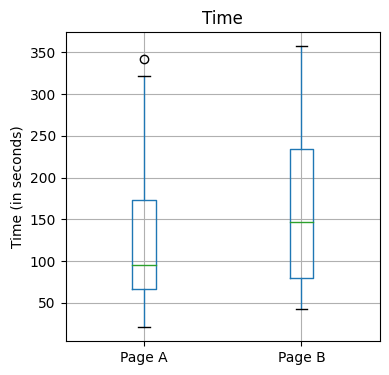

In [4]:
ax = session_times.boxplot(by='Page', column='Time', figsize=(4,4))
ax.set_xlabel('')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')

plt.tight_layout()
plt.show()

This figure indicates that page B leads to longer sessions than page A. 

The means for each group can be computed by filtering the `pandas` data frame first by page and then determine the mean of the `Time` column:

In [5]:
mean_a = session_times[session_times.Page == 'Page A'].Time.mean()
mean_b = session_times[session_times.Page == 'Page B'].Time.mean()
print(mean_b - mean_a)

35.66666666666667


Page B has session times that are greater than those of page A by 35.67 seconds, on average. 

The question is whether this difference is within the range of what random chance might produce, i.e., **is statistically significant**. 

One way to answer this is to apply a **permutation test**—combine all the session times together and then repeatedly shuffle and divide them into groups of 21 (recall that n<sub>A</sub> = 21 for page A) and 15 (n<sub>B</sub> = 15 for page B).

To apply a permutation test, we need a function to randomly assign the 36 session times to a group of 21 (page A) and a group of 15 (page B). 

Let's implement this permutation test.

In [14]:
# Permutation test example with stickiness
def perm_fun(x, nA, nB):
    n = nA + nB
    idx_B = set(random.sample(range(n), nB))
    idx_A = set(range(n)) - idx_B
    return x.loc[idx_B].mean() - x.loc[idx_A].mean()
    
nA = session_times[session_times.Page == 'Page A'].shape[0]
nB = session_times[session_times.Page == 'Page B'].shape[0]
print(perm_fun(session_times.Time, nA, nB))

11.095238095238074


This function works by sampling (without replacement) n<sub>B</sub> indices and assigning them to the B group; the remaining n<sub>A</sub> indices are assigned to group A. 

The difference between the two means is returned. 

Calling this function R = 1,000 times and specifying n<sub>A</sub> = 21 and n<sub>B</sub> = 15 leads to a distribution of differences in the session times that can be plotted as a histogram.

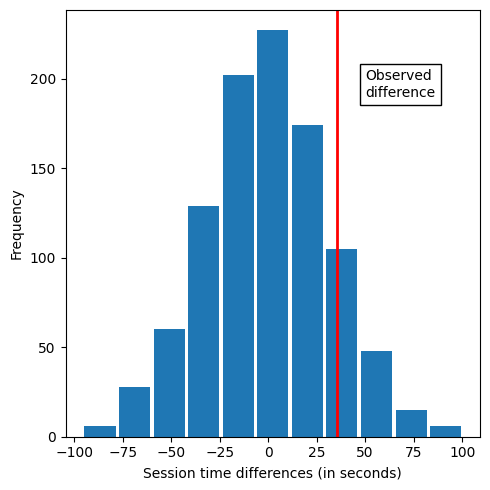

In [17]:
random.seed(1)
perm_diffs = [perm_fun(session_times.Time, nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color='r', lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

This figure shows frequency distribution for session time differences between pages A and B; the vertical line shows the observed difference.

The histogram (frequency distribution) shows that mean difference of random permutations often exceeds the observed difference in session times (the vertical line). 

For our results, this happens in 12.1% of the cases. 

Note that as the simulation uses random numbers, the percentage will vary. 

This suggests that the observed difference in session time between page A and page B is well within the range of chance variation and thus is **not statistically significant**.

In [18]:
#print(np.mean(perm_diffs > mean_b - mean_a))
#type(perm_diffs) # list
#type(mean_b - mean_a) # float
perm_diffs_float = np.array(perm_diffs,dtype=float)
print(np.mean(perm_diffs_float > mean_b - mean_a))

0.121


**Key Ideas**

* In a permutation test, multiple samples are combined and then shuffled.
* The shuffled values are then divided into resamples, and the statistic of interest is calculated.
* This process is then repeated, and the resampled statistic is tabulated.
* Comparing the observed value of the statistic to the resampled distribution allows you to judge whether an observed difference between samples might occur by chance.

# Statistical Significance and P-Values

Statistical significance is how statisticians measure whether an experiment (or even a study of existing data) yields a result more extreme than what chance might produce. 

If the result is beyond the realm of chance variation, it is said to be **statistically significant**.

### Key terms for statistical significance and p-values

**P-value**<br/>
Given a chance model that embodies the null hypothesis, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

**Alpha**<br/>
The probability threshold of “unusualness” that chance results must surpass for actual outcomes to be deemed statistically significant.

**Type 1 error (False positive)**<br/>
Mistakenly concluding an effect is real (when it is due to chance).

**Type 2 error (False negative)**<br/>
Mistakenly concluding an effect is due to chance (when it is real).

### Example:  Ecommerce experiment results

<img src="ecommerce_exp_results.png">

Price A converts almost 5% better than price B (0.8425% = 200/(23539+200)x100, versus 0.8057% = 182/(22406+182)x100—a difference of 0.0368 percentage points).

We can test whether the difference in coversions between prices A and B is within the rage of chance variation, using a resampling procedure. 

By chance variation, we mean the random variation produced by a probability model that embodies the null hypothesis that there is no difference between the rates. 

The following permutation procedure asks, “If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?”

1. Put cards labeled 1 and 0 in a box: this represents the supposed shared conversion rate of 382 ones and 45,945 zeros = 0.008246 = 0.8246%.
2. Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
3. Record the number of 1s in the remaining 22,588 (same n as price B).
4. Record the difference in proportion of 1s.
5. Repeat steps 2–4.
6. How often was the difference >= 0.0368?

Observed difference: 0.0368%


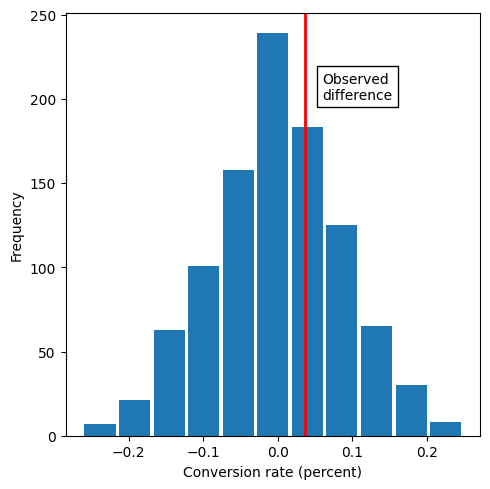

In [19]:
random.seed(1)
# observed percentage difference
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f'Observed difference: {obs_pct_diff:.4f}%')

conversion = [0] * 45945   # we have over 45,000 data points
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

# Reusing the function perm_fun, we can create a histogram of randomly permuted differences in conversion rate
perm_diffs = [100 * perm_fun(conversion, 23739, 22588) 
              for _ in range(1000)]

fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='r', lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

See the histogram of 1,000 resampled results in Figure above: as it happens, in this case the observed difference of 0.0368% is well within the range of chance variation.

## P-Value

Simply looking at the graph is not a very precise way to measure statistical significance, so of more interest is the *p-value*. 

This is the frequency with which the chance model produces a result more extreme than the observed result. 

We can estimate a p-value from our permutation test by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference:

If `np.mean` is applied to a list of booleans, it gives the percentage of how often True was found in the list (#True / #Total).

In [20]:
print(np.mean([diff > obs_pct_diff for diff in perm_diffs]))

0.332


The p-value is 0.332, which means that we would expect to achieve a result as extreme as this, or a more extreme result, by random chance over 30% of the time.

### Practical significance
Even if a result is statistically significant, that does not mean it has practical significance. 

A small difference that has no practical meaning can be statistically significant if it arose from large enough samples. 

Large samples ensure that small, non-meaningful effects can nonetheless be big enough to rule out chance as an explanation. 

Ruling out chance does not magically render important a result that is, in its essence, unimportant.

# Type 1 and Type 2 Errors

<img src="type-I_type-II_error.png">

In assessing statistical significance, two types of error are possible:
* A Type 1 error, in which you mistakenly conclude an effect is real, when it is really just due to chance
* A Type 2 error, in which you mistakenly conclude that an effect is not real (i.e., due to chance), when it actually is real

Actually, a Type 2 error is not so much an error as a judgment that the sample size is too small to detect the effect. 

When a p-value falls short of statistical significance (e.g., it exceeds 5%), what we are really saying is “effect not proven.” It could be that a larger sample would yield a smaller p-value.

The basic function of significance tests (also called hypothesis tests) is to protect against being fooled by random chance; thus they are typically structured to minimize Type 1 errors.

# Data Science and P-values
The work that data scientists do is typically not destined for publication in scientific journals, so the debate over the value of a p-value is somewhat academic. 

For a data scientist, a p-value is a useful metric in situations where you want to know whether a model result that appears interesting and useful is within the range of normal chance variability. 

As a decision tool in an experiment, a p-value should not be considered controlling, but merely another point of information bearing on a decision. 

For example, p-values are sometimes used as intermediate inputs in some statistical or machine learning models—a feature might be included in or excluded from a model depending on its p-value.